In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import sys
from itertools import product
from time import time

import numpy as np
from sklearn.svm import LinearSVC

sys.path.append('/home/share/libraries/bdpy/')
import bdpy
from bdpy.preproc import select_top
from bdpy.ml import add_bias,make_cvindex
from bdpy.stats import corrcoef
sys.path.append('/home/shirakawa/kspy/')
import cal_mean_ci


%matplotlib inline

In [2]:
# loading data
atrial = pd.read_csv("Atrial.csv", header=None) # (time *  cell)
ventricle = pd.read_csv("Ventricle.csv",header = None) # time * cell)
# transposing for training
atrial = atrial.T
ventricle = ventricle.T
# get number of samples 
[N,c] = np.shape(atrial)
[M,C] = np.shape(ventricle)

aFPow = np.zeros(4500/2)
vFPow = np.zeros(4500/2)
featnum = len(aFPow)
# get Power Spectrum
for i in range(1,N):
    
    adata = atrial.iloc[i][3:].astype(float)
    
    F = np.fft.fft(adata)
    aF = np.abs(F)**2
    aF = aF[:featnum]
    aFPow = np.vstack([aFPow,aF])
aFPow = aFPow[1:,:]    

for i in range(1,M):
    
    vdata = ventricle.iloc[i][3:].astype(float)
    
    F = np.fft.fft(vdata)
    vF = np.abs(F)**2
    vF = vF[:featnum]
    vFPow = np.vstack([vFPow,vF])
vFPow = vFPow[1:,:]    


# get minimum for chance level is 50 % (-1 means datas' index exclude)
n = np.min([N-1,M-1])


In [3]:
vFPow

array([[  1.90126170e+08,   1.55418632e+05,   1.85167315e+04, ...,
          2.22239374e+04,   1.90116266e+04,   3.04558577e+04],
       [  3.44154033e+08,   5.11357962e+04,   2.29775234e+05, ...,
          9.39198664e+03,   1.09055871e+02,   3.51801535e+04],
       [  2.38433783e+08,   1.86643550e+04,   5.10572314e+04, ...,
          1.53405584e+04,   8.98550530e+03,   2.10752940e+02],
       ..., 
       [  2.26790749e+07,   2.68708112e+04,   3.79686991e+04, ...,
          2.19035144e+02,   4.55737644e+02,   7.81361528e+02],
       [  1.95073547e+07,   5.05256748e+03,   6.52990479e+03, ...,
          2.22686921e+03,   2.28175988e+03,   6.54165734e+02],
       [  2.84235327e+06,   1.52760870e+04,   1.34527105e+04, ...,
          8.63853016e+01,   1.16240073e+01,   2.42807777e+02]])

In [45]:
# random select and iteration
mean = []
std  = []
for num in range(1,2250):
    if num%100 == 0:
        print num
    if num < 400 or num % 50 == 0:
        for epch in range(10):
            # shuffle each order and each number of sample is same
            Nind =range(1,N)
            Mind = range(1,M)
            aFPow_rand = np.random.permutation(aFPow)
            vFPow_rand = np.random.permutation(vFPow)
            

            aFPow_rand = aFPow[:n]
            vFPow_rand = vFPow[:n]
            #make lable atrial -> 0 ventricle ->1
            alabel = np.zeros([n,1])
            vlabel = np.ones([n,1])

            #make data of label and Poewer spectrum
            aData = np.hstack([alabel,aFPow_rand])
            vData = np.hstack([vlabel,vFPow_rand])

            #create a and v mixed Data
            raw_Data = np.vstack([aData,vData])
            numacc = []
            
    
            #print ('try feature'+ str(num))
            # we select num features
            Data = raw_Data[:,:num+1]
            # make index for cross validation
            index = np.shape(Data)[0]
            ind = np.arange(index)
            # make cvindex 10-fold cross validation
            cvidx = make_cvindex(ind %10)

            # do cross validation
            accuracy = []
            for i in range(10):
                trainData = Data[cvidx[0][:,i] == True]
                testData = Data[cvidx[1][:,i]== True]
                X_train = trainData[:,1:]
                y_train = trainData[:,0]
                X_test= testData[:,1:]
                y_test = testData[:,0]
                # normalizing 
                mu_train = np.mean(X_train,0)
                sigma_train = np.std(X_train,0)
                X_train_std = (X_train - mu_train)/sigma_train
                X_test_std = (X_test - mu_train)/sigma_train
                clf =  LinearSVC(random_state= 0)
                clf.fit(X_train_std,y_train)
                predict = clf.predict(X_test_std)

                accuracy.append(clf.score(X_test_std,y_test))
            
    mean.append(np.mean(accuracy))
    std.append(np.std(accuracy))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


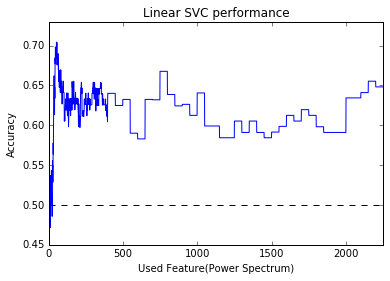

In [49]:
# make figure
plt.plot(mean)
plt.xlabel('Used Feature(Power Spectrum)')
plt.ylabel('Accuracy')
plt.title('Linear SVC performance')
plt.xlim([0,2250])
plt.ylim([0.45,0.73])
plt.axhline(0.5,color = 'black',linestyle ='--')
plt.savefig('iPS_linearSVC.pdf')

In [50]:
#save
np.save('mean_Linear.npy',mean)
np.save('std_Linear.npy',std)

In [22]:
len(Mind)

71

In [25]:
np.random.permutation?

In [30]:
aFPow_rand = np.random.permutation(aFPow)

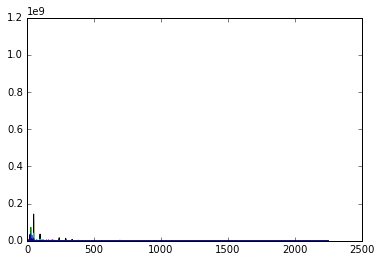

In [31]:
plt.plot(aFPow_rand.T)

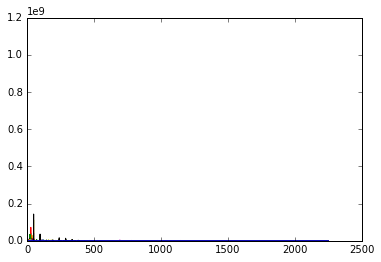

In [32]:
plt.plot(aFPow.T)